In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import (load_config, seed_everything, pairwise_comparison, volcano_plot)

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

In [3]:
data_mat = pd.read_csv('../results/misc/data_mat_filter_norm.csv')
data_mat.drop(['sample'], axis=1, inplace=True)
data_mat.shape

(78, 190)

### Statistical approach

In [4]:
# pairwise comparisons
french_lmu = pairwise_comparison(data_mat, class1='LMU', class2='French')
french_dunn = pairwise_comparison(data_mat, class1='Dunn', class2='French')
lmu_dunn = pairwise_comparison(data_mat, class1='Dunn', class2='LMU')

# concat all
all_pair_res = pd.concat([french_lmu, french_dunn, lmu_dunn], axis=0)

# adjust pvalues function
all_pair_res['padj'] = all_pair_res['p_value'] * len(all_pair_res)
all_pair_res['padj'] = all_pair_res['padj'].clip(upper=1)
all_pair_res.head()


,feature,p_value,log2FC,Group,padj
162,FT-221,1.113629e-35,0.745741,French_vs_LMU,6.314276e-33
152,FT-050,5.453371e-43,0.734115,French_vs_LMU,3.092061e-40
155,FT-043,2.098805e-38,0.730485,French_vs_LMU,1.190023e-35
120,FT-046,2.739051e-42,0.705918,French_vs_LMU,1.553042e-39
173,FT-200,5.662616e-08,0.511315,French_vs_LMU,3.210703e-05


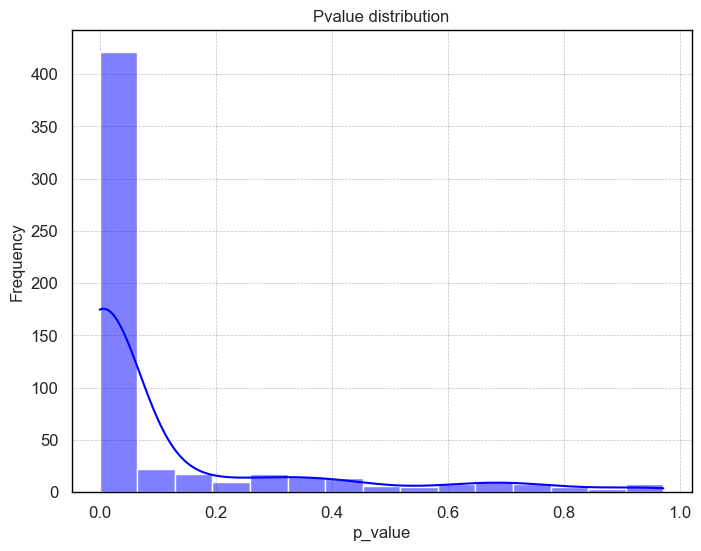

In [5]:
# pvalue distribution
plt.figure()
sns.histplot(all_pair_res['p_value'], bins=15, kde=True, color='blue')
plt.ylabel('Frequency')
plt.title('Pvalue distribution')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.savefig(f"{config['paths']['figures_dir']}/pval_distribution.png")
plt.show()

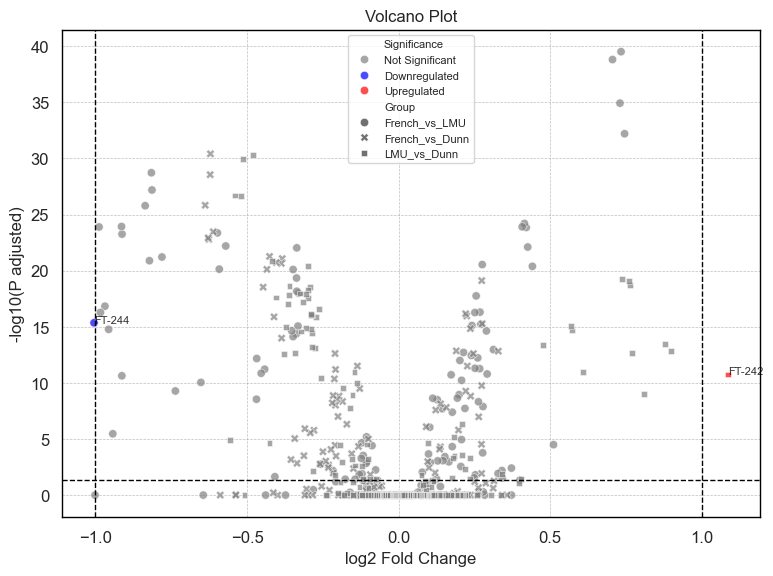

In [6]:
volcano_plot(
     all_pair_res.copy(), log2fc_col='log2FC', padj_col='padj', feature_col='feature',
     group_col='Group', significance_threshold=0.05, fc_threshold=1.0, 
     save_path=f"{config['paths']['figures_dir']}/volcano_plot.png"
 )


In [ ]:
# MA plot